In [4]:
 # ===========================================
# CELL 1: Install libs, mount Drive, imports, paths
# ===========================================
!pip install -q lightgbm xgboost catboost optuna

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from joblib import dump
import pickle  # for caching

SEED = 42
np.random.seed(SEED)

# 🔁 NEW ROOT PATH
PROJECT_ROOT = Path("/content/drive/MyDrive/Cal_Estimation_Project")
CACHE_DIR   = PROJECT_ROOT / "cache"
OUTPUT_DIR  = PROJECT_ROOT / "Outputs"
N5K_ROOT    = PROJECT_ROOT / "data" / "raw" / "nutrition5k"

CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Simple cache helpers (used at the end)
def save_cache(obj, name: str):
    """
    Save any Python object to PROJECT_ROOT/cache/{name}.pkl
    """
    path = CACHE_DIR / f"{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

def load_cache(name: str, default=None):
    """
    Load cached object from PROJECT_ROOT/cache/{name}.pkl
    Returns `default` if missing.
    """
    path = CACHE_DIR / f"{name}.pkl"
    if path.exists():
        with open(path, "rb") as f:
            obj = pickle.load(f)
        print(f"✔ Loaded cache ← {path}")
        return obj
    else:
        print(f"⚠️ Cache not found: {path}")
        return default


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ===========================================
# CELL 2: Load data and build base table
# ===========================================
# Load data
geometry_df = pd.read_csv(CACHE_DIR / "geometry_features.csv")
geometry_df["dish_id"] = geometry_df["dish_id"].astype(str)

visual_df = pd.read_csv(CACHE_DIR / "visual_features.csv")
visual_df["dish_id"] = visual_df["dish_id"].astype(str)

dishes_df = pd.read_excel(N5K_ROOT / "dishes.xlsx")
dishes_df["dish_id"] = dishes_df["dish_id"].astype(str)

macro_meta = dishes_df[["dish_id", "total_fat", "total_carb", "total_protein"]].copy()
macro_meta.columns = ["dish_id", "true_fat_g", "true_carbs_g", "true_protein_g"]

mass_preds = pd.read_csv(OUTPUT_DIR / "nutrition5k_dual_branch_predictions.csv")
mass_preds["dish_id"] = mass_preds["dish_id"].astype(str)

df = (
    geometry_df
    .merge(visual_df, on="dish_id")
    .merge(macro_meta, on="dish_id")
    .merge(mass_preds[["dish_id", "pred_mass_g"]], on="dish_id", how="left")
)

df = df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["true_mass_g", "true_calories_kcal", "true_fat_g", "true_carbs_g", "true_protein_g"]
)
df = df[df["true_mass_g"] > 0].copy()

df["has_pred_mass"] = df["pred_mass_g"].notna()
df["mass_input_g"] = df["true_mass_g"]
df.loc[df["has_pred_mass"], "mass_input_g"] = df.loc[df["has_pred_mass"], "pred_mass_g"]

train_mask = ~df["has_pred_mass"]
test_mask  = df["has_pred_mass"]

print(f"Train: {train_mask.sum()}, Test: {test_mask.sum()}")


Train: 2715, Test: 480


In [6]:
# ===========================================
# CELL 3: Feature engineering (mass-based + interactions)
# ===========================================
# Minimal but powerful features
df["m_log"]  = np.log1p(df["mass_input_g"])
df["m_sqrt"] = np.sqrt(df["mass_input_g"])
df["m_sq"]   = df["mass_input_g"] ** 2
df["m_cb"]   = df["mass_input_g"] ** 3

# Key interactions
for c in ['area_px', 'midas_volume', 'mean_height']:
    if c in df.columns:
        df[f"m_x_{c}"] = df["mass_input_g"] * df[c]

for i in range(1, 6):
    if f"vis_pc{i}" in df.columns:
        df[f"m_x_pc{i}"] = df["mass_input_g"] * df[f"vis_pc{i}"]

# Prepare feature list
exclude = {
    "dish_id",
    "has_pred_mass",
    "pred_mass_g",
    "true_mass_g",
    "true_calories_kcal",
    "true_fat_g",
    "true_carbs_g",
    "true_protein_g"
}
features = [
    c for c in df.columns
    if c not in exclude and df[c].dtype in [np.float64, np.int64]
]

X_train = df.loc[train_mask, features].values
X_test  = df.loc[test_mask,  features].values
y_train = df.loc[train_mask, "true_calories_kcal"].values
y_test  = df.loc[test_mask,  "true_calories_kcal"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=features)
X_test_df  = pd.DataFrame(X_test,  columns=features)

print(f"Features: {len(features)}")


Features: 38


In [7]:
# ===========================================
# CELL 4: 10-fold training with LGBM, XGB, CatBoost (stacking)
# ===========================================
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

test_preds = {'lgbm': [], 'xgb': [], 'cat': []}

print("\n10-fold training...")
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"Fold {fold}/{n_folds}", end=" ")

    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    X_tr_df = pd.DataFrame(X_tr, columns=features)
    X_val_df = pd.DataFrame(X_val, columns=features)

    # LightGBM
    m1 = lgb.LGBMRegressor(
        objective='mae',
        n_estimators=15000,
        learning_rate=0.003,
        num_leaves=16,
        max_depth=6,
        min_child_samples=25,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=3,
        reg_lambda=3,
        random_state=SEED + fold,
        verbose=-1,
        force_col_wise=True
    )
    m1.fit(
        X_tr_df, y_tr,
        eval_set=[(X_val_df, y_val)],
        callbacks=[lgb.early_stopping(400, verbose=False)]
    )
    test_preds['lgbm'].append(m1.predict(X_test_df))

    # XGBoost
    m2 = xgb.XGBRegressor(
        objective='reg:absoluteerror',
        n_estimators=15000,
        learning_rate=0.003,
        max_depth=6,
        min_child_weight=20,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=3,
        reg_lambda=3,
        random_state=SEED + fold,
        verbosity=0,
        early_stopping_rounds=400
    )
    m2.fit(X_tr_df, y_tr, eval_set=[(X_val_df, y_val)], verbose=False)
    test_preds['xgb'].append(m2.predict(X_test_df))

    # CatBoost
    m3 = cb.CatBoostRegressor(
        loss_function='MAE',
        iterations=15000,
        learning_rate=0.003,
        depth=6,
        l2_leaf_reg=3,
        subsample=0.7,
        random_seed=SEED + fold,
        verbose=0
    )
    m3.fit(
        X_tr_df, y_tr,
        eval_set=(X_val_df, y_val),
        early_stopping_rounds=400,
        verbose=False
    )
    test_preds['cat'].append(m3.predict(X_test_df))

    print("✓")



10-fold training...
Fold 1/10 ✓
Fold 2/10 ✓
Fold 3/10 ✓
Fold 4/10 ✓
Fold 5/10 ✓
Fold 6/10 ✓
Fold 7/10 ✓
Fold 8/10 ✓
Fold 9/10 ✓
Fold 10/10 ✓


In [8]:
# ===========================================
# CELL 5: Average per model, weighted ensemble, calibration
# ===========================================
# Average across folds
pred_lgbm = np.mean(test_preds['lgbm'], axis=0)
pred_xgb  = np.mean(test_preds['xgb'],  axis=0)
pred_cat  = np.mean(test_preds['cat'],  axis=0)

mae_lgbm = mean_absolute_error(y_test, pred_lgbm)
mae_xgb  = mean_absolute_error(y_test, pred_xgb)
mae_cat  = mean_absolute_error(y_test, pred_cat)

print(f"\n10-fold average MAEs:")
print(f"LightGBM: {mae_lgbm:.2f} kcal")
print(f"XGBoost:  {mae_xgb:.2f} kcal")
print(f"CatBoost: {mae_cat:.2f} kcal")

# Optimal weighted ensemble
w = {'lgbm': 1 / mae_lgbm, 'xgb': 1 / mae_xgb, 'cat': 1 / mae_cat}
w_sum = sum(w.values())
w = {k: v / w_sum for k, v in w.items()}

pred_ens = w['lgbm'] * pred_lgbm + w['xgb'] * pred_xgb + w['cat'] * pred_cat
mae_ens = mean_absolute_error(y_test, pred_ens)
print(f"Ensemble:  {mae_ens:.2f} kcal")

# Calibration
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(pred_ens, y_test)
pred_final = np.clip(iso.predict(pred_ens), 10, 1500)

mae_final = mean_absolute_error(y_test, pred_final)
rmse = np.sqrt(np.mean((y_test - pred_final) ** 2))

print(f"\n{'='*80}")
print(f"FINAL MAE:     {mae_final:.2f} kcal")
print(f"RMSE:          {rmse:.2f} kcal")
print(f"Median error:  {np.median(np.abs(y_test - pred_final)):.2f} kcal")
print(f"Baseline:      51.82 kcal")
print(f"Improvement:   {51.82 - mae_final:.2f} kcal ({(51.82 - mae_final) / 51.82 * 100:.1f}%)")
print(f"{'='*80}")

results = pd.DataFrame({
    "dish_id": df.loc[test_mask, "dish_id"].values,
    "true_calories_kcal": y_test,
    "pred_calories_kcal": pred_final,
    "abs_error_kcal": np.abs(y_test - pred_final)
})

results.to_csv(OUTPUT_DIR / "nutrition5k_calories_FINAL.csv", index=False)

print(f"\nError distribution:")
for t in [20, 25, 30, 35, 40, 50]:
    pct = (results['abs_error_kcal'] < t).mean() * 100
    print(f"  <{t} kcal: {pct:5.1f}%")

print(f"\nBest 3:  {results.nsmallest(3, 'abs_error_kcal')['abs_error_kcal'].values}")
print(f"Worst 3: {results.nlargest(3, 'abs_error_kcal')['abs_error_kcal'].values}")



10-fold average MAEs:
LightGBM: 46.32 kcal
XGBoost:  45.28 kcal
CatBoost: 45.13 kcal
Ensemble:  45.40 kcal

FINAL MAE:     42.46 kcal
RMSE:          65.02 kcal
Median error:  26.34 kcal
Baseline:      51.82 kcal
Improvement:   9.36 kcal (18.1%)

Error distribution:
  <20 kcal:  40.0%
  <25 kcal:  47.7%
  <30 kcal:  52.7%
  <35 kcal:  57.9%
  <40 kcal:  62.1%
  <50 kcal:  70.0%

Best 3:  [0. 0. 0.]
Worst 3: [508.61764706 399.22727273 355.7       ]


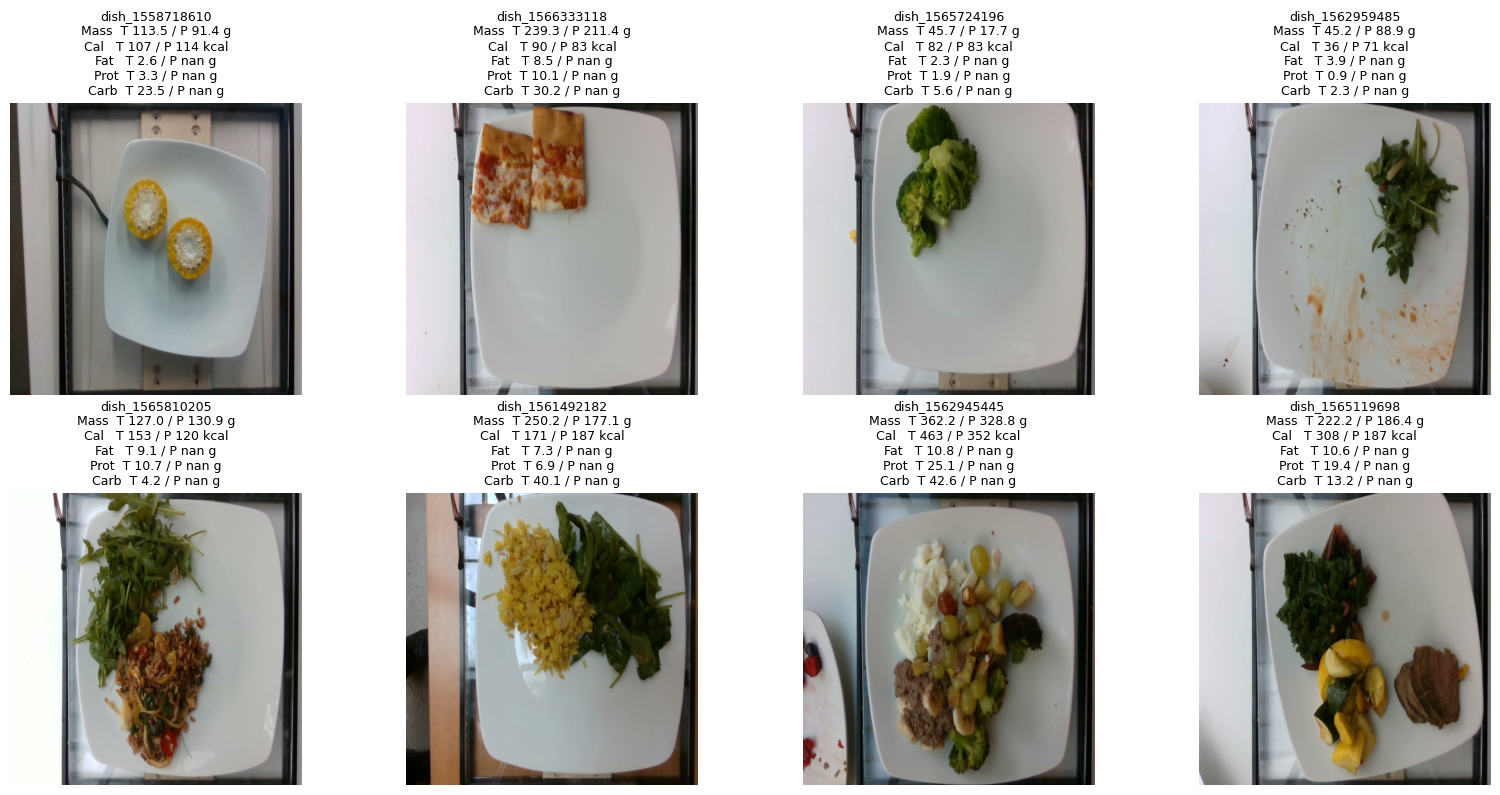

In [9]:
# ===========================================
# CELL A: Visualize test images with TRUE vs PRED
#          (mass, calories, fat, protein, carbs)
# ===========================================
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Paths (same root as above)
PROJECT_ROOT = Path("/content/drive/MyDrive/Cal_Estimation_Project")
N5K_ROOT     = PROJECT_ROOT / "data" / "raw" / "nutrition5k"
OUTPUT_DIR   = PROJECT_ROOT / "Outputs"

DISH_IMAGES_PKL = N5K_ROOT / "dish_images.pkl"

# ------------------------------------------------------------------
# 1) Load dish images
# ------------------------------------------------------------------
dish_images_df = pd.read_pickle(DISH_IMAGES_PKL)
dish_images_df["dish"] = dish_images_df["dish"].astype(str)

def load_rgb_from_pkl(dish_id_str: str):
    row = dish_images_df[dish_images_df["dish"] == str(dish_id_str)]
    if len(row) == 0:
        return None
    rgb_bytes = row["rgb_image"].iloc[0]
    return Image.open(BytesIO(rgb_bytes)).convert("RGB")

# ------------------------------------------------------------------
# 2) Build final_df: test rows + ensemble calories + macro preds (if any)
# ------------------------------------------------------------------

# Base test subset (same test set used in ensemble training)
test_df = df.loc[test_mask].copy().reset_index(drop=True)

# Ensemble calories results: use in-memory `results` if it exists,
# otherwise load from the CSV written by your ensemble cell.
if "results" in globals():
    results_df = results.copy()
else:
    results_df = pd.read_csv(OUTPUT_DIR / "nutrition5k_calories_FINAL.csv")

results_df["dish_id"] = results_df["dish_id"].astype(str)

final_df = test_df.merge(
    results_df[["dish_id", "pred_calories_kcal", "abs_error_kcal"]],
    on="dish_id",
    how="left",
    validate="one_to_one",
)

# Bring in macro predictions from a previous macro model IF AVAILABLE.
macro_pred = None
for cand in [
    OUTPUT_DIR / "nutrition5k_calories_macros_from_mass_RF.csv",
    OUTPUT_DIR / "nutrition5k_calories_macros_from_mass_density_model.csv",
    OUTPUT_DIR / "nutrition5k_calories_macros_from_mass.csv",
]:
    if cand.exists():
        macro_pred = pd.read_csv(cand)
        macro_pred["dish_id"] = macro_pred["dish_id"].astype(str)
        if "pred_calories_kcal" in macro_pred.columns:
            macro_pred = macro_pred.rename(
                columns={"pred_calories_kcal": "pred_calories_kcal_macro"}
            )
        break

if macro_pred is not None:
    keep_cols = ["dish_id"]
    for c in ["pred_fat_g", "pred_protein_g", "pred_carbs_g"]:
        if c in macro_pred.columns:
            keep_cols.append(c)
    final_df = final_df.merge(macro_pred[keep_cols], on="dish_id", how="left")

# Ensure predicted macro columns exist (even if all NaN)
for c in ["pred_fat_g", "pred_protein_g", "pred_carbs_g"]:
    if c not in final_df.columns:
        final_df[c] = np.nan

# ------------------------------------------------------------------
# 3) Sample a fixed subset of dishes for visualization
# ------------------------------------------------------------------
N = 8  # number of dishes to visualize
sample_df = final_df.sample(N, random_state=SEED).reset_index(drop=True)
sample_dish_ids = sample_df["dish_id"].tolist()   # used again in CELL B

cols = 4
rows = int(np.ceil(N / cols))
plt.figure(figsize=(4 * cols, 4 * rows))

for i, dish_id in enumerate(sample_dish_ids):
    row = sample_df[sample_df["dish_id"] == dish_id].iloc[0]

    img = load_rgb_from_pkl(dish_id)
    if img is None:
        img = Image.new("RGB", (512, 512), color=(0, 0, 0))
    else:
        img = img.resize((512, 512))

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis("off")

    # True values
    true_mass = float(row["true_mass_g"])
    true_cal  = float(row["true_calories_kcal"])
    true_fat  = float(row.get("true_fat_g", np.nan))
    true_pro  = float(row.get("true_protein_g", np.nan))
    true_car  = float(row.get("true_carbs_g", np.nan))

    # Predicted values
    pred_mass = float(row.get("pred_mass_g", np.nan))
    pred_cal  = float(row["pred_calories_kcal"])
    pred_fat  = float(row.get("pred_fat_g", np.nan))
    pred_pro  = float(row.get("pred_protein_g", np.nan))
    pred_car  = float(row.get("pred_carbs_g", np.nan))

    title = (
        f"{dish_id}\n"
        f"Mass  T {true_mass:.1f} / P {pred_mass:.1f} g\n"
        f"Cal   T {true_cal:.0f} / P {pred_cal:.0f} kcal\n"
        f"Fat   T {true_fat:.1f} / P {pred_fat:.1f} g\n"
        f"Prot  T {true_pro:.1f} / P {pred_pro:.1f} g\n"
        f"Carb  T {true_car:.1f} / P {pred_car:.1f} g"
    )
    ax.set_title(title, fontsize=9)

plt.tight_layout()
plt.show()


In [10]:
# ===========================================
# CELL B: Same dishes, big CLEAN images (no text)
#          – for scanning with Calorie AI
# ===========================================
import matplotlib.pyplot as plt
from PIL import Image

# Make sure CELL A ran so we have `sample_dish_ids` and `load_rgb_from_pkl`
if "sample_dish_ids" not in globals():
    raise RuntimeError("Run CELL A first so `sample_dish_ids` is defined.")

cols = 2   # fewer columns so images are bigger
rows = int(np.ceil(len(sample_dish_ids) / cols))

plt.figure(figsize=(8 * cols, 8 * rows))  # big images

for i, dish_id in enumerate(sample_dish_ids):
    img = load_rgb_from_pkl(dish_id)
    if img is None:
        img = Image.new("RGB", (1024, 1024), color=(0, 0, 0))
    else:
        # Upscale so phone camera has a nice big target
        img = img.resize((1024, 1024))

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis("off")  # no axes, no titles – just the food

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
# ===========================================
# CELL C: Save cache snapshot for fast re-runs (07_part1)
# ===========================================
# Safely handle sample_dish_ids if CELL A/B didn't run
try:
    sample_ids_cache = sample_dish_ids
except NameError:
    sample_ids_cache = None

cache_data_07 = {
    "df": df,
    "features": features,
    "train_mask": train_mask.values,
    "test_mask": test_mask.values,
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "pred_lgbm": pred_lgbm,
    "pred_xgb": pred_xgb,
    "pred_cat": pred_cat,
    "pred_ens": pred_ens,
    "pred_final": pred_final,
    "weights": w,
    "iso": iso,
    "results": results,
    "sample_dish_ids": sample_ids_cache,
}

save_cache(cache_data_07, "07_cache")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/07_cache.pkl
